In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Lambda,Activation,Masking,BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras.layers import TimeDistributed

from sklearn.preprocessing import normalize

import pandas as pd
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt
import keras

import warnings
from math import log
# import wtte.weibull as weibull
# import wtte.wtte as wtte
# from wtte.wtte import WeightWatcher

np.random.seed(2)
pd.set_option("display.max_rows",1000)

Using TensorFlow backend.


In [ ]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [ ]:
train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [ ]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True).head(300)

op_setting_1  ...  sensor_measurement_21
unit_number time                ...                       
1           1           0.0023  ...                23.3735
            2          -0.0027  ...                23.3916
            3           0.0003  ...                23.4166
            4           0.0042  ...                23.3737
            5           0.0014  ...                23.4130
            6           0.0012  ...                23.3467
            7          -0.0000  ...                23.3952
            8           0.0006  ...                23.3224
            9          -0.0036  ...                23.4521
            10         -0.0025  ...                23.3820
            11          0.0007  ...                23.3609
            12          0.0026  ...                23.3845
            13         -0.0056  ...                23.3677
            14          0.0017  ...                23.4572
            15         -0.0003  ...                23.3672
            16         -0.0018  ...                23.3484
            17          0.0014  ...                23.3409
            18          0.0035  ...                23.4481
            19          0.0029  ...                23.3809
            20          0.0011  ...                23.3325
            21          0.0038  ...                23.4025
            22          0.0012  ...                23.3770
            23          0.0009  ...                23.3186
            24         -0.0006  ...                23.3971
            25          0.0028  ...                23.3785
            26          0.0047  ...                23.3557
            27         -0.0007  ...                23.3931
            28          0.0022  ...                23.3502
            29          0.0014  ...                23.3621
            30         -0.0025  ...                23.4069
            31         -0.0006  ...                23.3552
2           1          -0.0009  ...                23.3923
            2          -0.0011  ...                23.2902
            3           0.0002  ...                23.4064
            4           0.0025  ...                23.4699
            5           0.0004  ...                23.3895
            6          -0.0008  ...                23.2688
            7           0.0019  ...                23.5222
            8           0.0015  ...                23.2240
            9          -0.0022  ...                23.2730
            10          0.0021  ...                23.3399
            11         -0.0010  ...                23.3423
            12          0.0022  ...                23.2849
            13          0.0034  ...                23.3169
            14         -0.0013  ...                23.3479
            15         -0.0009  ...                23.3930
            16          0.0018  ...                23.3610
            17         -0.0012  ...                23.2601
            18          0.0005  ...                23.2268
            19          0.0005  ...                23.3142
            20          0.0039  ...                23.2495
            21         -0.0038  ...                23.3836
            22          0.0005  ...                23.2475
            23         -0.0003  ...                23.3193
            24          0.0010  ...                23.2738
            25          0.0014  ...                23.3787
            26          0.0012  ...                23.2403
            27         -0.0009  ...                23.2959
            28         -0.0008  ...                23.3570
            29         -0.0015  ...                23.3035
            30          0.0015  ...                23.3048
            31          0.0003  ...                23.3065
            32          0.0032  ...                23.3139
            33         -0.0006  ...                23.3074
            34         -0.0033  ...                23.2535
            35         -0.0033  ...                23.3074
      

In [ ]:
test_x_orig.shape

(13096, 26)

In [ ]:
# train_orig.set_index(['unit_number', 'time'], verify_integrity=True).head(300)

In [ ]:
train_orig.shape

(20631, 26)

In [ ]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them, 
all_data_orig = pd.concat([train_orig, test_x_orig])
# all_data = all_data[feature_cols]
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

scaler=pipeline.Pipeline(steps=[
#     ('z-scale', StandardScaler()),
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']], scaler.fit_transform(all_data[feature_cols])], axis=1)

In [ ]:
all_data.shape

(33727, 19)

In [ ]:
# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [ ]:
train.shape

(20631, 19)

In [ ]:
import tqdm
from tqdm import tqdm

# TODO: replace using wtte data pipeline routine
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []

    n_engines=100
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            engine_x = x[engine == i]

            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
#             xtemp = np.full((1, max_time, d), mask_value)
            
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [ ]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

train_x, train_y = build_data(engine=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time, is_test=False, mask_value=mask_value)
test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)

100%|██████████| 100/100 [00:00<00:00, 9744.22it/s]


In [ ]:
test_y = test_y_orig.copy()
test_y['E'] = 1

In [ ]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (20631, 100, 17) train_y (20631, 2) test_x (100, 100, 17) test_y (100, 2)


In [ ]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


In [ ]:
K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

epsilon 1e-10


# **loglikelihood + activation**

In [ ]:
#@title
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

In [ ]:
#@title
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))

In [ ]:
#@title
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

# **WTTE package 코드**

In [ ]:
#@title
def _keras_unstack_hack(ab):
    ndim = len(K.int_shape(ab))
    if ndim == 0:
        print('can not unstack with ndim=0')
    else:
        a = ab[..., 0]
        b = ab[..., 1]
    return a, b

In [ ]:
#@title
def output_lambda(x, init_alpha=1.0, max_beta_value=5.0, scalefactor=None,
                  alpha_kernel_scalefactor=None):
  
    if max_beta_value is None or max_beta_value > 3:
        if K.epsilon() > 1e-07 and K.backend() == 'tensorflow':
            message = "\
            Using tensorflow backend and allowing high `max_beta_value` may lead to\n\
            gradient NaN during training unless `K.epsilon()` is small.\n\
            Call `keras.backend.set_epsilon(1e-08)` to lower epsilon \
            "
            warnings.warn(message)
    if alpha_kernel_scalefactor is not None:
        message = "`alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.\n Setting `scalefactor = alpha_kernel_scalefactor`"
        warnings.warn(message)
        scalefactor = alpha_kernel_scalefactor

    a, b = _keras_unstack_hack(x)

    if scalefactor is not None:
        # Done after due to theano bug.
        a, b = scalefactor * a, scalefactor * b

    # Implicitly initialize alpha:
    a = init_alpha * K.exp(a)

    if max_beta_value > 1.05:  # some value >>1.0
        # shift to start around 1.0
        # assuming input is around 0.0
        _shift = np.log(max_beta_value - 1.0)

        b = b - _shift

    b = max_beta_value * K.sigmoid(b)

    x = K.stack([a, b], axis=-1)

    return x


In [ ]:
#@title
def loglik_discrete(y, u, a, b, epsilon=K.epsilon()):
    hazard0 = K.pow((y + epsilon) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)

    loglikelihoods = u * \
        K.log(K.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return loglikelihoods


def loglik_continuous(y, u, a, b, epsilon=K.epsilon()):
    ya = (y + epsilon) / a
    loglikelihoods = u * (K.log(b) + b * K.log(ya)) - K.pow(ya, b)
    return loglikelihoods


def loglik_continuous_conditional_correction(y, u, a, b, epsilon=K.epsilon()):
    """Integrated conditional excess loss.
        Explanation TODO
    """
    ya = (y + epsilon) / a
    loglikelihoods = y * \
        (u * (K.log(b) + b * K.log(ya)) - (b / (b + 1.)) * K.pow(ya, b))
    return loglikelihoods

In [ ]:
#@title
def _keras_split(y_true, y_pred):
    """
        Everything is a hack around the y_true,y_pred paradigm.
    """
    y, u = _keras_unstack_hack(y_true)
    a, b = _keras_unstack_hack(y_pred)

    return y, u, a, b

keras_split = _keras_split

In [ ]:
#@title
class Loss(object):
    def __init__(self,
                 kind,
                 reduce_loss=True,
                 clip_prob=1e-6,
                 regularize=False,
                 location=None,
                 growth=None):

        self.kind = kind
        self.reduce_loss = reduce_loss
        self.clip_prob = clip_prob

        if regularize == True or location is not None or growth is not None:
            raise DeprecationWarning('Directly penalizing beta has been found \
                                      to be unneccessary when using bounded activation \
                                      and clipping of log-likelihood.\
                                      Use this method instead.')

    def loss_function(self, y_true, y_pred):
      
        y, u, a, b = _keras_split(y_true, y_pred)
        if self.kind == 'discrete':
            loglikelihoods = loglik_discrete(y, u, a, b)
        elif self.kind == 'continuous':
            loglikelihoods = loglik_continuous(y, u, a, b)

        if self.clip_prob is not None:
            loglikelihoods = K.clip(loglikelihoods, 
                log(self.clip_prob), log(1 - self.clip_prob))
        if self.reduce_loss:
            loss = -1.0 * K.mean(loglikelihoods, axis=-1)
        else:
            loss = -loglikelihoods

        return loss

# For backwards-compatibility
loss = Loss


In [ ]:
#@title
class WeightWatcher(callbacks.Callback):
    """Keras Callback to keep an eye on output layer weights.
        (under development)
        Usage:
            weightwatcher = WeightWatcher(per_batch=True,per_epoch=False)
            model.fit(...,callbacks=[weightwatcher])
            weightwatcher.plot()
    """

    def __init__(self,
                 per_batch=False,
                 per_epoch=True
                 ):
        self.per_batch = per_batch
        self.per_epoch = per_epoch

    def on_train_begin(self, logs={}):
        self.a_weights_mean = []
        self.b_weights_mean = []
        self.a_weights_min = []
        self.b_weights_min = []
        self.a_weights_max = []
        self.b_weights_max = []
        self.a_bias = []
        self.b_bias = []

    def append_metrics(self):
        # Last two weightlayers in model

        output_weights, output_biases = self.model.get_weights()[-2:]

        a_weights_mean, b_weights_mean = output_weights.mean(0)
        a_weights_min, b_weights_min = output_weights.min(0)
        a_weights_max, b_weights_max = output_weights.max(0)

        a_bias, b_bias = output_biases

        self.a_weights_mean.append(a_weights_mean)
        self.b_weights_mean.append(b_weights_mean)
        self.a_weights_min.append(a_weights_min)
        self.b_weights_min.append(b_weights_min)
        self.a_weights_max.append(a_weights_max)
        self.b_weights_max.append(b_weights_max)
        self.a_bias.append(a_bias)
        self.b_bias.append(b_bias)

    def on_train_end(self, logs={}):
        if self.per_epoch:
            self.append_metrics()
        return

    def on_epoch_begin(self, epoch, logs={}):
        if self.per_epoch:
            self.append_metrics()
        return

    def on_epoch_end(self, epoch, logs={}):
        return

    def on_batch_begin(self, batch, logs={}):
        if self.per_batch:
            self.append_metrics()
        return

    def on_batch_end(self, batch, logs={}):
        if self.per_batch:
            self.append_metrics()
        return

    def plot(self):
        import matplotlib.pyplot as plt

        # Create axes
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(self.a_bias, color='b')
        ax1.set_xlabel('step')
        ax1.set_ylabel('alpha')

        ax2.plot(self.b_bias, color='r')
        ax2.set_ylabel('beta')

        # Change color of each axis
        def color_y_axis(ax, color):
            """Color your axes."""
            for t in ax.get_yticklabels():
                t.set_color(color)
            return None

        plt.title('biases')
        color_y_axis(ax1, 'b')
        color_y_axis(ax2, 'r')
        plt.show()

        ###############
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        ax1.plot(self.a_weights_min, color='blue',
                 linestyle='dotted', label='min', linewidth=2)
        ax1.plot(self.a_weights_mean, color='blue',
                 linestyle='solid', label='mean', linewidth=1)
        ax1.plot(self.a_weights_max, color='blue',
                 linestyle='dotted', label='max', linewidth=2)

        ax1.set_xlabel('step')
        ax1.set_ylabel('alpha')

        ax2.plot(self.b_weights_min, color='red',
                 linestyle='dotted', linewidth=2)
        ax2.plot(self.b_weights_mean, color='red',
                 linestyle='solid', linewidth=1)
        ax2.plot(self.b_weights_max, color='red',
                 linestyle='dotted', linewidth=2)
        ax2.set_ylabel('beta')

        # Change color of each axis
        def color_y_axis(ax, color):
            """Color your axes."""
            for t in ax.get_yticklabels():
                t.set_color(color)
            return None

        plt.title('weights (min,mean,max)')
        color_y_axis(ax1, 'b')
        color_y_axis(ax2, 'r')
        plt.show()

In [ ]:
history = History()
weightwatcher = WeightWatcher()
nanterminator = callbacks.TerminateOnNaN()
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
#                                         factor=0.5, 
#                                         patience=50, 
#                                         verbose=0, 
#                                         mode='auto', 
#                                         epsilon=0.0001, 
#                                         cooldown=0, 
#                                         min_lr=1e-8)

n_features = train_x.shape[-1]

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))

# model.add(BatchNormalization())

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
# model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))
model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))

# model.add(Dense(20))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
# model.add(TimeDistributed(Dense(2)))
model.add(Dense(2))

# Apply the custom activation function mentioned above
# model.add(Activation(activate))

model.add(Lambda(output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = Loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=Adam(lr=.01, clipvalue=0.5))
# model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 17)          0         
_________________________________________________________________
gru (GRU)                    (None, 20)                2340      
_________________________________________________________________
dense (Dense)                (None, 2)                 42        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0         
Total params: 2,382
Trainable params: 2,382
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 30
n_batch = 100
n_train = train_x.shape[0]
n_test = test_x.shape[0]
steps_per_epoch = n_train//n_batch
validation_steps = n_test//n_batch
print(steps_per_epoch, validation_steps)   # test_set을 좀 더 늘리자.

206 1


In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(n_batch).repeat()
# test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(n_batch)

In [ ]:
# model.fit(train_dataset, epochs = n_epochs, steps_per_epoch=steps_per_epoch,
#           validation_data=test_dataset,
#           callbacks=[history, nanterminator,weightwatcher])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  # Remove the CWD from sys.path while we load stuff.


206/206 [==============================] - 60s 291ms/step - loss: 5.1269 - val_loss: 4.7497
Epoch 2/30
206/206 [==============================] - 62s 300ms/step - loss: 5.0417 - val_loss: 4.7075
Epoch 3/30
206/206 [==============================] - 60s 292ms/step - loss: 4.9584 - val_loss: 4.7617
Epoch 4/30
206/206 [==============================] - 60s 290ms/step - loss: 4.9237 - val_loss: 4.7612
Epoch 5/30
206/206 [==============================] - 60s 291ms/step - loss: 4.9471 - val_loss: 4.7851
Epoch 6/30
206/206 [==============================] - 58s 282ms/step - loss: 4.9460 - val_loss: 4.6153
Epoch 7/30
206/206 [==============================] - 60s 291ms/step - loss: 4.9050 - val_loss: 4.6614
Epoch 8/30
206/206 [==============================] - 61s 297ms/step - loss: 4.8779 - val_loss: 4.5922
Epoch 9/30
206/206 [==============================] - 61s 294ms/step - loss: 4.8033 - val_loss: 4.6294
Epoch 10/30
206/206 [==============================] - 60s 290ms/step - loss: 4.8862

In [ ]:
model.fit(train_x, train_y,
              epochs=30,
              batch_size=100, 
              verbose=1,
              validation_data=(test_x, test_y),
              callbacks=[history, nanterminator,weightwatcher]
          )

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  # Remove the CWD from sys.path while we load stuff.


207/207 [==============================] - 60s 292ms/step - loss: 4.6077 - val_loss: 4.5506


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  # Remove the CWD from sys.path while we load stuff.


Epoch 2/30
207/207 [==============================] - 59s 285ms/step - loss: 4.5244 - val_loss: 4.4127
Epoch 3/30
207/207 [==============================] - 60s 288ms/step - loss: 4.4844 - val_loss: 4.4204
Epoch 4/30
207/207 [==============================] - 60s 287ms/step - loss: 4.4463 - val_loss: 4.3635
Epoch 5/30
207/207 [==============================] - 59s 287ms/step - loss: 4.4192 - val_loss: 4.3016
Epoch 6/30
207/207 [==============================] - 60s 292ms/step - loss: 4.3983 - val_loss: 4.3151
Epoch 7/30
207/207 [==============================] - 61s 296ms/step - loss: 4.3495 - val_loss: 4.2662
Epoch 8/30
207/207 [==============================] - 60s 291ms/step - loss: 4.3329 - val_loss: 4.2436
Epoch 9/30
207/207 [==============================] - 61s 293ms/step - loss: 4.3227 - val_loss: 4.2144
Epoch 10/30
207/207 [==============================] - 60s 291ms/step - loss: 4.2741 - val_loss: 4.3247
Epoch 11/30
207/207 [==============================] - 60s 290ms/step - 

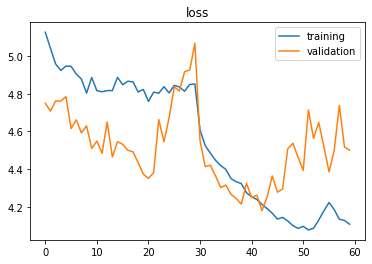

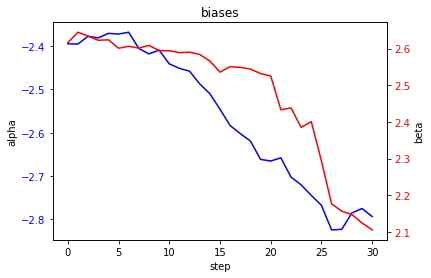

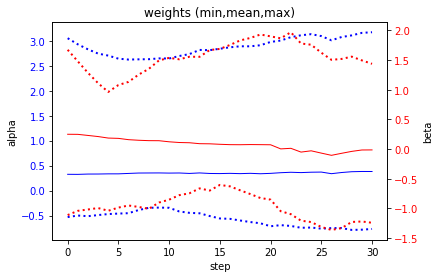

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

In [ ]:
test_predict = model.predict(test_x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
test_predict

array([[164.53703  ,   5.7246847],
       [141.82816  ,   5.866357 ],
       [ 73.40771  ,   9.146384 ],
       [ 86.62697  ,   6.179    ],
       [ 84.74286  ,   6.251183 ],
       [124.36645  ,   5.796316 ],
       [118.298256 ,   4.921044 ],
       [ 86.08769  ,   6.2626534],
       [131.94046  ,   6.0907116],
       [114.098335 ,   4.599518 ],
       [137.13612  ,   7.7100306],
       [126.154625 ,   3.4326508],
       [106.54468  ,   3.9533908],
       [176.71394  ,   7.1420827],
       [124.95104  ,   6.091966 ],
       [168.80174  ,   3.576937 ],
       [ 53.713158 ,   5.412193 ],
       [ 44.097343 ,   5.3174214],
       [ 95.40585  ,   4.999728 ],
       [ 15.69733  ,   5.9756064],
       [ 92.94732  ,   6.04826  ],
       [153.48688  ,   6.6029015],
       [155.38237  ,   5.341037 ],
       [ 23.126066 ,  10.043336 ],
       [179.92729  ,   5.5966506],
       [227.18608  ,   3.4549675],
       [100.45543  ,   5.455259 ],
       [ 87.446434 ,   5.4483685],
       [115.815025 ,

In [ ]:
test_result = np.concatenate((test_y, test_predict), axis=1)

In [ ]:
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

In [ ]:
test_results_df.head()

,T,E,alpha,beta,unit_number
0,112.0,1.0,164.537033,5.724685,1
1,98.0,1.0,141.828156,5.866357,2
2,69.0,1.0,73.407707,9.146384,3
3,82.0,1.0,86.626968,6.179000,4
4,91.0,1.0,84.742859,6.251183,5


In [ ]:
from google.colab import drive

In [ ]:
import os
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/'My Drive'/'Colab Notebooks'/'Time-to-Event'

/content/drive/My Drive/Colab Notebooks/Time-to-Event


In [ ]:
test_results_df.to_csv('test_results_df')

In [ ]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

alpha 97.55123178482056 beta 5.921699106693268


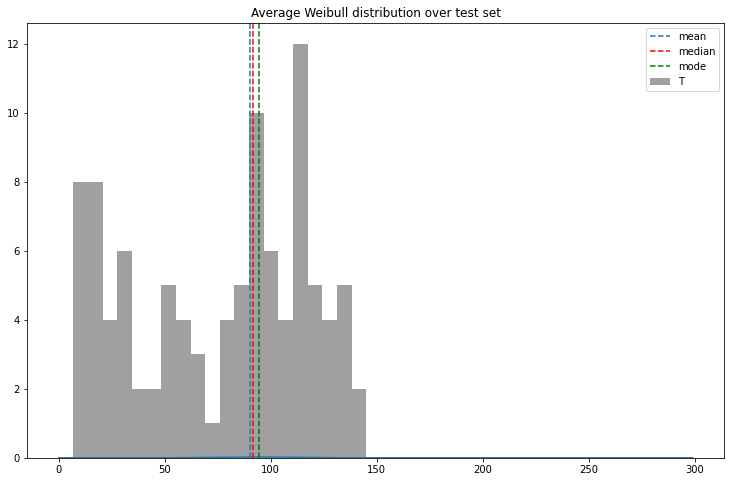

In [ ]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

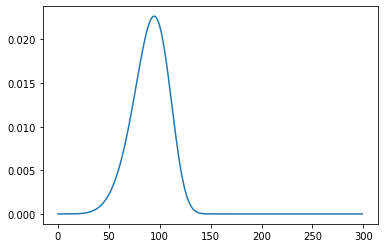

In [ ]:
plt.plot(t, weibull_pdf(alpha,beta, t))

In [ ]:
import seaborn as sns
palette=sns.color_palette("RdBu_r", 50)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


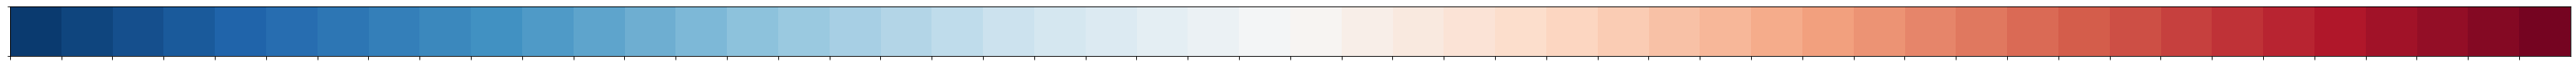

In [ ]:
sns.palplot(palette)

In [ ]:
feature_columns = [x for x in test_x_orig.columns if x not in {'unit_number', 'time'}]

mins=train_orig[feature_columns].min()
maxs=train_orig[feature_columns].max()

for unit_no, grp in test_x_orig.groupby('unit_number'):
    df=grp.set_index('time')
    df = df[feature_columns]
    df=(df - mins)/ (maxs - mins)
    df.plot(figsize=(12.5,8))
    plt.title(unit_no)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')
#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

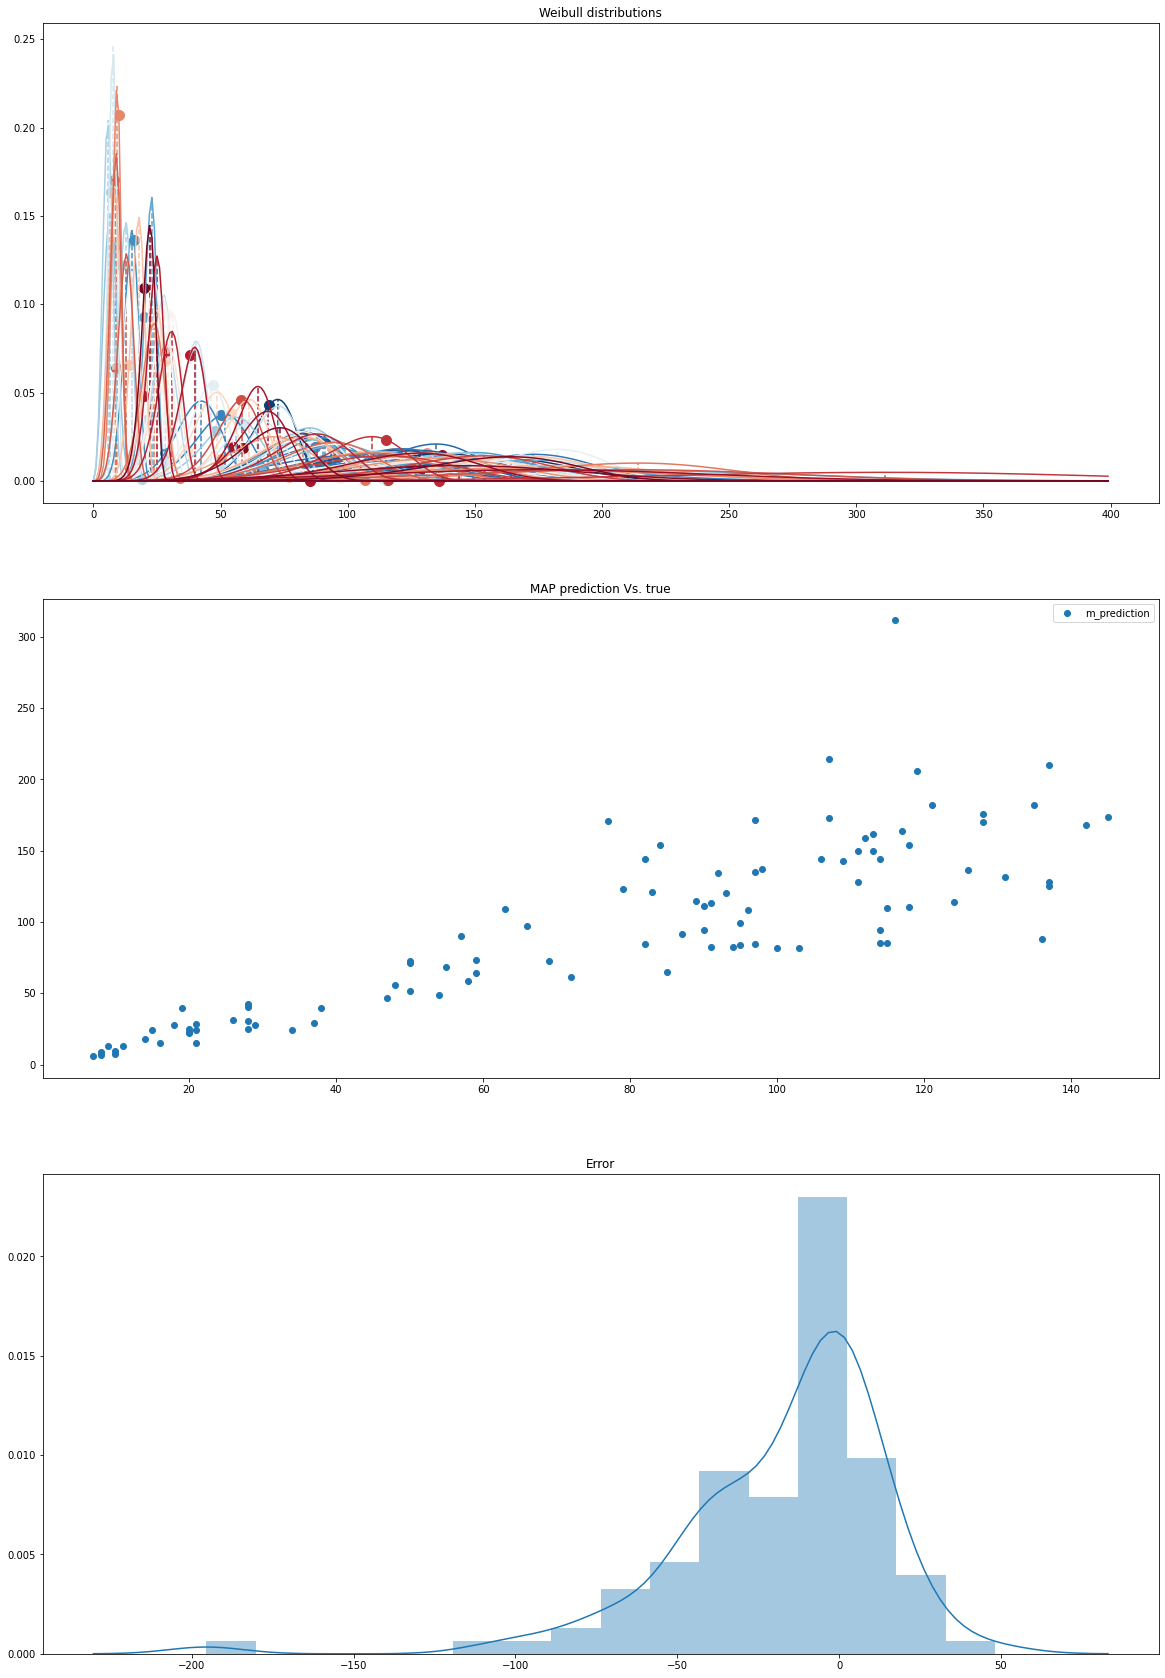

In [ ]:
plot_weibull_predictions(results_df=test_results_df)

In [ ]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

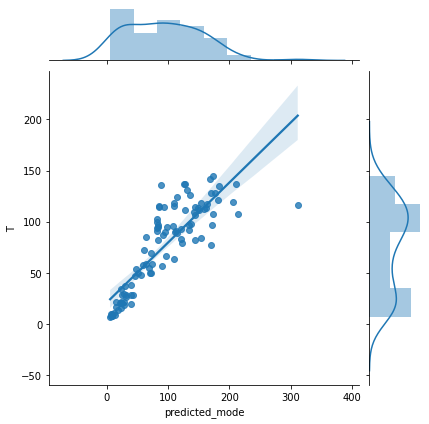

In [ ]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode',kind="reg")

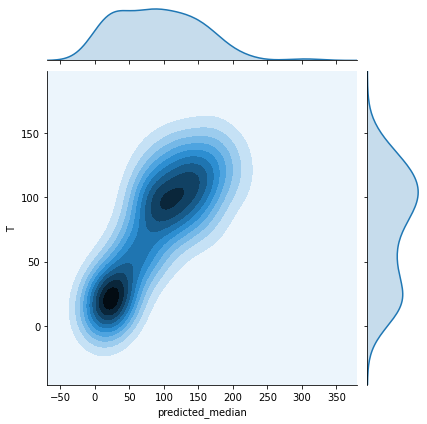

In [ ]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median',kind="kde" )

In [ ]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']

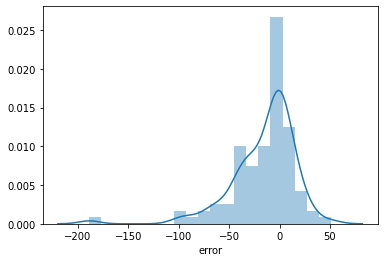

In [ ]:
sns.distplot(test_results_df['error'], bins=20)

In [ ]:
test_y.shape

(100, 2)

In [ ]:
train_y.shape

(20631, 2)

In [ ]:
train_predict = model.predict(train_x)

In [ ]:
train_predict.shape

(20631, 2)

In [ ]:
train_result = np.concatenate((train_y, train_predict),axis=1)

In [ ]:
train_result

array([[192.        ,   1.        , 221.14712524,   5.07467222],
       [191.        ,   1.        , 224.37197876,   4.7353549 ],
       [190.        ,   1.        , 229.11247253,   4.8751936 ],
       ...,
       [  3.        ,   1.        ,   5.25760221,   2.80423713],
       [  2.        ,   1.        ,   4.20479631,   3.00251031],
       [  1.        ,   1.        ,   3.23610592,   1.80655062]])

In [ ]:
train_results_df = pd.DataFrame(train_result, columns=['T','E','alpha','beta'])

In [ ]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]

In [ ]:
train_results_df    #여기서 n time 후 고장률? 식으로.. 

,T,E,alpha,beta,unit_number,time
0,192.0,1.0,221.147125,5.074672,1,1
1,191.0,1.0,224.371979,4.735355,1,2
2,190.0,1.0,229.112473,4.875194,1,3
3,189.0,1.0,238.924118,5.276865,1,4
4,188.0,1.0,233.638535,5.267848,1,5
...,...,...,...,...,...,...
20626,5.0,1.0,6.524090,3.542106,100,196
20627,4.0,1.0,6.351160,3.071025,100,197
20628,3.0,1.0,5.257602,2.804237,100,198
20629,2.0,1.0,4.204796,3.002510,100,199


In [ ]:
train_results_df.to_csv('train_results_df')

In [ ]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp)

Output hidden; open in https://colab.research.google.com to view.